Impotar las librerías

In [2]:
import pandas as pd
import mysql.connector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

Genero el df con los datos del mysql

In [3]:
conexion = mysql.connector.connect(user ='admin', password = 'migration2023', host = 'database-migration.cq1xp27nrjmz.us-east-2.rds.amazonaws.com', database = 'migration', port = '3306')
conexion

In [4]:
indicadores = pd.read_sql("SELECT * FROM migration.indicadores", conexion)
indicadores

C:\Users\I5\AppData\Local\Temp\ipykernel_20164\3899417809.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  indicadores = pd.read_sql("SELECT * FROM migration.indicadores", conexion)


,Año,Pais,Codigo_Pais,Crecimiento_PIB,Tasa_desempleo,Inflacion_PIB,Homicidios_intencionales,Muertes_Conflicto,Control_Corrupcion,Emisiones_CO2,Esperanza_vida,Migracion_neta,Poblacion_total
0,2000,Argentina,ARG,-0.788999,15.000,1.037287,0.000000,0.0,52.127659,132265.5,73.926000,-22770.0,3.707077e+07
1,2000,Australia,AUS,3.901171,6.280,2.560384,1.903464,0.0,93.617020,339422.8,79.234146,109375.0,1.902880e+07
2,2000,Brazil,BRA,4.387949,10.530,5.606065,25.799761,0.0,57.978722,313670.8,69.737000,-1761.0,1.758737e+08
3,2000,China,CHN,8.490093,3.260,2.062793,0.000000,0.0,49.468086,3346525.8,71.881000,-549792.0,1.262645e+09
4,2000,France,FRA,3.923669,10.220,1.553290,1.791514,0.0,88.829788,373235.8,79.056098,102857.0,6.092138e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,2020,Virgin Islands (U.S.),VIR,-2.147007,13.255,4.353670,0.000000,0.0,58.173077,0.0,79.819512,0.0,1.062900e+05
4553,2020,West Bank and Gaza,PSE,-11.318466,25.890,2.220902,0.956289,0.0,31.250000,0.0,74.403000,-12369.0,4.803269e+06
4554,2020,"Yemen, Rep.",YEM,0.000000,13.575,0.000000,0.000000,2369.0,0.961538,9960.1,64.650000,-86100.0,3.228405e+07
4555,2020,Zambia,ZMB,-2.785055,6.030,13.743502,0.000000,0.0,26.442308,7607.1,62.380000,9015.0,1.892772e+07


Hago un csv con los datos para utilizar en el main

In [5]:
indicadores.to_csv('indicadores.csv', index = False)

Hago la correlacion de los datos con respecto a la variable objetivo

In [6]:
columnas_numericas = indicadores.select_dtypes(include=['float64', 'int64']).columns.difference(["Poblacion_total", "Año", "Pais", "Codigo_Pais"])
matriz_correlacion = indicadores[columnas_numericas].corr()
correlaciones_migracion = matriz_correlacion["Migracion_neta"]
correlaciones_migracion

Control_Corrupcion          0.207497
Crecimiento_PIB            -0.000273
Emisiones_CO2               0.190827
Esperanza_vida              0.094256
Homicidios_intencionales   -0.033264
Inflacion_PIB              -0.016504
Migracion_neta              1.000000
Muertes_Conflicto          -0.222162
Tasa_desempleo              0.001762
Name: Migracion_neta, dtype: float64

Lo grafico para que quede mejor explicado

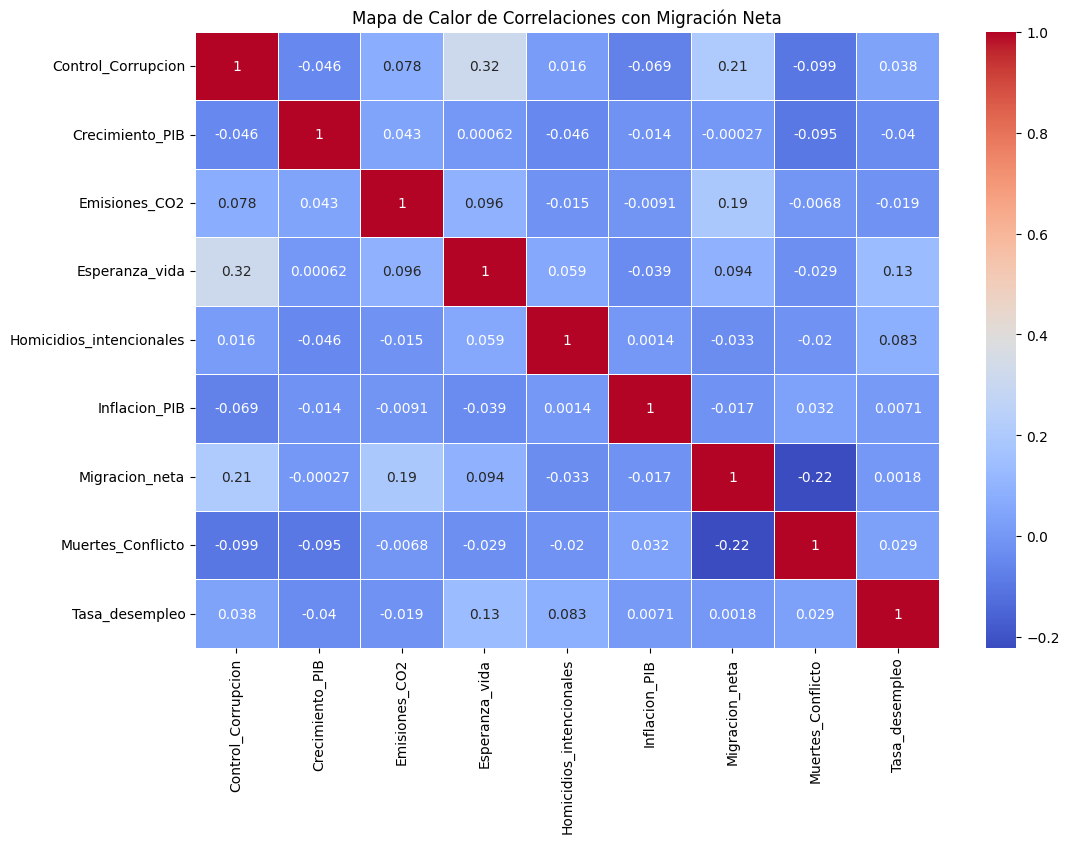

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de Calor de Correlaciones con Migración Neta")
plt.show()

Entreno el modelo

In [8]:
X = indicadores[["Crecimiento_PIB", "Tasa_desempleo", "Inflacion_PIB", "Control_Corrupcion", "Emisiones_CO2","Esperanza_vida"]]
y = indicadores["Migracion_neta"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = modelo.predict(X_test)

Me fijo el mse y el r2 para ver la exactitud del modelo

In [12]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

Error cuadrático medio (MSE): 28199374030.51673
Coeficiente de determinación (R^2): 0.016765118659573308


In [13]:
def obtener_predicciones_por_pais(df, modelo):
    predicciones_por_pais = pd.DataFrame()
    for index, fila in df.iterrows():
        variables_independientes = fila[["Crecimiento_PIB", "Tasa_desempleo", "Inflacion_PIB", "Control_Corrupcion", "Emisiones_CO2","Esperanza_vida"]].values.reshape(1, -1)
        prediccion = modelo.predict(variables_independientes)[0]
        pais = fila["Migracion_neta"]
        predicciones_por_pais = predicciones_por_pais.append({"País": pais, "Predicción": prediccion}, ignore_index=True)
    return predicciones_por_pais

In [14]:
predicciones = obtener_predicciones_por_pais(indicadores, modelo)
predicciones

c:\Users\I5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\I5\AppData\Local\Temp\ipykernel_20164\3469838815.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predicciones_por_pais = predicciones_por_pais.append({"País": pais, "Predicción": prediccion}, ignore_index=True)
c:\Users\I5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\I5\AppData\Local\Temp\ipykernel_20164\3469838815.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predicciones_por_pais = predicciones_por_pais.append({"País": pais, "P

,País,Predicción
0,-22770.0,6618.292078
1,109375.0,65299.194262
2,-1761.0,25195.881235
3,-549792.0,189449.990478
4,102857.0,61875.563830
...,...,...
4552,0.0,5996.089310
4553,-12369.0,-28939.214614
4554,-86100.0,-54103.401599
4555,9015.0,-29322.751043
